<img width="6%" alt="pyTCR.png" src="./images/logo.png" style="border-radius: 15%">

# PyTCR - Example 2: Tropical cyclone rainfall generation

**Author:** [Phong Le](https://github.com/levuvietphong)

**Description:** This notebook reads tropical cyclone track outputs obtained from the statistical-dynamical [tropical cyclone downscaling model](https://github.com/linjonathan/tropical_cyclone_risk) and generate rainfall driven by tropical cyclones.


### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc
import warnings
warnings.filterwarnings("ignore")

import tcr.rainfall as tcr_rain
import tcr.wind as tcr_wind
import tcr.iodata as tcr_io
import tcr.convert as tcr_convert
import tcr.plots as tcr_plot

### Map and plot configurations

In [2]:
# Mapping boundary and projection
xmin = -115; xmax = -45; dx = 10
ymin = 12; ymax = 48; dy = 10
extent = [xmin, xmax, ymin, ymax, dx, dy]

proj = ccrs.AzimuthalEquidistant(central_longitude=-80, central_latitude=30)

# Shapefile
fnCONUS = '../data/shapefiles/CONUS.shp'
shpCONUS = shpreader.Reader(fnCONUS)

# Plotting period
yearmin = 1964
yearmax = 2014
num_year = yearmax - yearmin + 1

### Load data from a CMIP6 model during historical period
In this notebook, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/).

In [3]:
pathdir = '../data/downscaled/historical/'
filename = 'tracks_NA_E3SM-1-0_historical_r1i1p1f1_196401_201412.nc'

# Load NetCDF data
ds, lat_trks, lon_trks, n_trk, v_trks, vmax_trks, u850_trks, v850_trks, \
    tc_month, tc_years, tc_time = tcr_io.load_NetCDF_data(pathdir, filename)

### Estimate the radius of the tropical cyclone based on circular wind speed.

In [4]:
# estimate_rm = True: will force to estimate the radius of maximum circular wind
# estimate_rm = False: will check if rm is already in the dataset. 
#   - if yes, it skips this step 
#   - if no, it will estimate rm
estimate_rm = False

# force to estimate the radius of maximum circular wind
if 'rm_trks' not in list(ds.keys()) or estimate_rm == True:
    print('Estimating the radius of maximum circular wind... ')
    rm_trks = tcr_wind.estimate_radius_wind(ds, lat_trks, vmax_trks, n_trk, pathdir, filename)
else:
    print('The radius of maximum circular wind was found in file!')
    print('Loading rm_trks...')
    rm_trks = ds['rm_trks'].values

The radius of maximum circular wind was found in file!
Loading rm_trks...


### Calculate accumulated rain and rainrates at specified locations for the active event set
- Currently, the TC downscaling model doesn't include any secondary eyewall effect.
- We temporarily set the secondary maximum wind speed and radius to zero

In [5]:
lat_poi = 29.5
lon_poi = -95.4

# Currently, no secondary rain bands
ut, vt, jmax = tcr_wind.utrans(lat_trks, lon_trks)

# Get datetime
date_trks = tcr_convert.to_datetime_from_netcdf(tc_years, tc_month, tc_time)

# Note: temporarily ignore secondary eyewalls
rain, rainrate, dayk = tcr_rain.raingen(lat_poi, lon_poi, lat_trks, lon_trks, date_trks, v_trks, rm_trks,
                                        0*v_trks, 0*rm_trks, u850_trks, v850_trks, ut, vt, T600=None)

### Calculate the spatial distribution of accumulated precipitation for a given individual storm.

In [6]:
# Select storm id 
storm_id = 527
x, y, netrain = tcr_rain.rainswathx(storm_id, lat_trks, lon_trks, rm_trks, v_trks, 0*rm_trks, 0*v_trks, ut, vt, u850_trks, v850_trks)

### Visualization

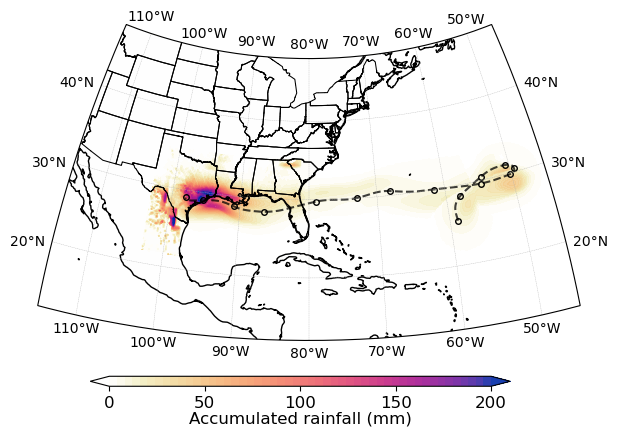

In [7]:
cmap = cc.cm.CET_L17
alpha = 0.9
max_precip = 200
levels = np.linspace(0, max_precip, 51)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w", subplot_kw=dict(projection=proj))

# PLOT Net Rainfall
im = tcr_plot.plot_density(ax, y, x, netrain, levels, extent=extent, alpha=alpha, cmap=cmap,
                           show_gridlabel=True, shapefile=shpCONUS)

ax.plot(lon_trks[storm_id, :], lat_trks[storm_id, :], color='k', ls='--',
        alpha=0.75, transform=ccrs.PlateCarree(), zorder=1)

# Show 15 dots along the track
ese = np.linspace(0, len(lon_trks[storm_id, :]) - 1, 15, dtype=int)
ax.plot(lon_trks[storm_id, ese], lat_trks[storm_id, ese], 'ok', ms=4,
        markerfacecolor='none', alpha=1, transform=ccrs.PlateCarree(), zorder=1)

# COLORBAR
cbax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Accumulated rainfall (mm)', fontsize=12, labelpad=0)
cb.set_ticks(np.linspace(0, max_precip, 5))
cb.ax.tick_params(labelsize=12)